# Momentum設定不同Lamda值實驗

### 有機會也應該玩玩RMSProp不同Alaph值

(Sgd) minimum result 
 cost         0.00247194
w       0.0754370817575
b        0.684077464902
Name: 296, dtype: object
It costs 0.597000 sec 

lamda=0.900000
(Momentum) minimum result 
 cost         0.00193165
w       0.0631797445743
b        0.749909000377
Name: 940, dtype: object
It costs 0.636000 sec 

lamda=0.600000
(Momentum) minimum result 
 cost         0.00193165
w       0.0631797445743
b        0.749909000377
Name: 940, dtype: object
It costs 0.612000 sec 

lamda=0.300000
(Momentum) minimum result 
 cost         0.00193165
w       0.0631797445743
b        0.749909000377
Name: 940, dtype: object
It costs 0.706000 sec 

lamda=0.000000
(Momentum) minimum result 
 cost         0.00193165
w       0.0631797445743
b        0.749909000377
Name: 940, dtype: object
It costs 0.873000 sec 

(closed-fom) w=0.0639, b= 0.7502


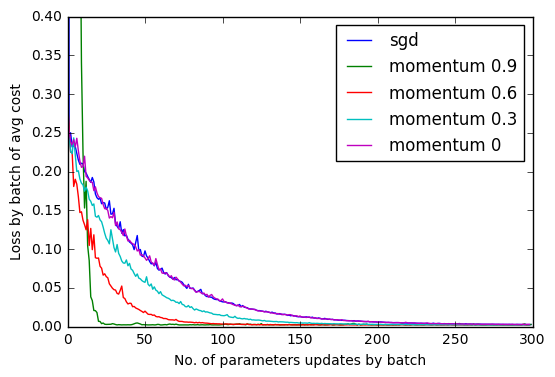

In [2]:
#http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex2/ex2.html

import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import time
import pandas as pd

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

### make batches
def mk_batches(x_data, y_data, batch_size, shuffle=False):
    x_batch = list()
    y_batch = list()
    
    x_data_size = x_data.shape[0]
    y_data_size = y_data.shape[0]
    assert x_data_size == y_data_size , 'the x, y dimension is error'
    
    if shuffle:
        indices = np.arange(x_data_size)
        np.random.shuffle(indices)
    
    #range(start, stop, step)
    for start_idx in range(0, x_data_size, batch_size):
        if shuffle:
            idx = indices[start_idx : start_idx + batch_size]            
        else:
            idx = slice(start_idx, start_idx + batch_size)
            
        x_batch.append(x_data[idx])
        y_batch.append(y_data[idx])
    
    return x_batch, y_batch
    
### data
batch_size = 10
x_data = floatX(np.loadtxt('.\ex2x.dat'))
y_data = floatX(np.loadtxt('.\ex2y.dat'))


### params / init weights
w = theano.shared(floatX(-1.))
b = theano.shared(floatX(-1.))

### model
x = T.vector()
y = w*x + b

### cost/error/loss
y_hat = T.vector()
cost = T.mean((y-y_hat)**2)

###############################################################################
### gradients
his_grad_dw = []
his_grad_db = []
second_dw = theano.shared(floatX(0.))
second_db = theano.shared(floatX(0.))

def gd(params, grads, lr):
    updates = []
        
    for p, g in it.izip(params, grads):
        updates.append([p, p - lr*g])

    return updates

his_move_dw = []
his_move_db = []
movement_dw = theano.shared(floatX(0.))
movement_db = theano.shared(floatX(0.))

def Momentum(params, grads):
    updates = []    
    
    updates.append([params[0], params[0] + movement_dw])
    
    updates.append([params[1], params[1] + movement_db])
    
    return updates
    
dw, db = T.grad(cost, [w, b])

###############################################################################
### calculate momentum
def calc_momentum(x, y, i, lamda):
    
    lr = 0.01
    v = 0
    
    g_dw = f_grad_dw(x, y)          
    g_db = f_grad_db(x, y) 
    
    if i == 0:        
        new_v = lamda * v - lr * g_dw
        his_move_dw.append(new_v)
        
        new_v = lamda * v - lr * g_db
        his_move_db.append(new_v)
    else:
        v = his_move_dw[i-1]
        new_v = lamda * v - lr * g_dw
        his_move_dw.append(new_v)
        
        v = his_move_db[i-1]
        new_v = lamda * v - lr * g_db
        his_move_db.append(new_v)
    
    movement_dw.set_value(floatX(his_move_dw[i]))    
    movement_db.set_value(floatX(his_move_db[i]))
    
###############################################################################
### theano function
f_model = theano.function([x], y)

f_cost = theano.function([x, y_hat], cost)

f_grad_dw = theano.function([x, y_hat], dw)

f_grad_db = theano.function([x, y_hat], db)

f_train = theano.function(inputs=[x, y_hat],
                          outputs=[cost, w, b],
                          updates=gd([w, b], [dw, db], 0.01))

f_train_momentum = theano.function(inputs=[x, y_hat],
                                   outputs=[cost, w, b],
                                   updates=Momentum([w, b], [dw, db]))

epochs = 300

###############################################################################
# training by gd
his_cost_by_gd = pd.DataFrame(columns=['cost', 'w', 'b'])
tStart = time.time()
for t in range(epochs):
        all_cost = 0
        all_w = 0
        all_b = 0
        
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):            
            tr_cost, tr_w, tr_b= f_train(x_batches[i], y_batches[i])            
            all_cost += tr_cost
        
        his_cost_by_gd.loc[t] = [all_cost/batch_num, tr_w, tr_b]

tEnd = time.time()
print '(Sgd) minimum result \n %s' % (his_cost_by_gd.loc[his_cost_by_gd['cost'].argmin()])
print 'It costs %f sec \n' % (tEnd-tStart)

###############################################################################
# training by momentum
lamdas = [0.9, 0.6, 0.3, 0.]
his_cost_by_momentum = pd.DataFrame(columns=['cost', 'w', 'b'])
ttt = 0

for l in range(len(lamdas)):

    his_move_dw = []
    his_move_db = []
    movement_dw.set_value(floatX(0.))
    movement_db.set_value(floatX(0.))
    
    w.set_value(floatX(-1.))
    b.set_value(floatX(-1.))    
    tStart = time.time()    

    tt = 0
    
    for t in range(epochs):
        
            all_cost = 0       
            x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
            batch_num = len(x_batches)      
                
            for i in range(batch_num):
                calc_momentum(x_batches[i], y_batches[i], tt, lamdas[l])            
                tr_cost, tr_w, tr_b= f_train_momentum(x_batches[i], y_batches[i])
                tt += 1
                ttt +=1
                all_cost += tr_cost            
                
            his_cost_by_momentum.loc[ttt] = [all_cost/batch_num, tr_w, tr_b]        
                
    tEnd = time.time()
    print 'lamda=%f' % lamdas[l]
    print '(Momentum) minimum result \n %s' % (his_cost_by_momentum.loc[his_cost_by_momentum['cost'].argmin()])
    print 'It costs %f sec \n' % (tEnd-tStart)

print '(closed-fom) w=0.0639, b= 0.7502'

###############################################################################
### cost chart

# 轉成np.array畫圖的時候 x軸才不會因為DataFrame的index而長的怪怪
# epochs = 300
plt.plot(np.array(his_cost_by_gd.iloc[:, 0]), label='sgd')
plt.plot(np.array(his_cost_by_momentum.iloc[0:300, 0]), label='momentum 0.9')
plt.plot(np.array(his_cost_by_momentum.iloc[301:600, 0]), label='momentum 0.6')
plt.plot(np.array(his_cost_by_momentum.iloc[601:900, 0]), label='momentum 0.3')
plt.plot(np.array(his_cost_by_momentum.iloc[901:1200, 0]), label='momentum 0')
plt.legend()
plt.xlabel("No. of parameters updates by batch")
plt.ylabel("Loss by batch of avg cost")
plt.ylim([0, 0.4])
plt.show()

## lamda值越大，下降速度越快

## lamda=0，等於不參考之前所有gradient的總和，結果其實就是再跑原本的gradient descent

## momentum 0 = sgd